In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
from gpt_index.readers.file.base import DEFAULT_FILE_EXTRACTOR, ImageParser
from gpt_index import SimpleDirectoryReader, GPTSimpleVectorIndex

In [94]:
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": ImageParser(keep_image=True, parse_text=True),
    ".png": ImageParser(keep_image=True, parse_text=True),
    ".jpeg": ImageParser(keep_image=True, parse_text=True),
})

In [112]:
# reader = SimpleDirectoryReader('../../docs/_static/indices', recursive=True, file_extractor=file_extractor)
# NOTE: processing 11 images is too slow, try with a few first

reader = SimpleDirectoryReader(
    input_files=[
        '../../docs/_static/indices/vector_store.png', 
        '../../docs/_static/indices/list.png',
        '../../docs/guides/index_guide.md',
    ], 
    file_extractor=file_extractor, 
    file_metadata=lambda filename: {'filename': filename}
)
documents = reader.load_data()

In [113]:
index = GPTSimpleVectorIndex(documents)

INFO:root:> [build_index_from_documents] Total LLM token usage: 0 tokens
INFO:root:> [build_index_from_documents] Total embedding token usage: 294 tokens


In [114]:
response = index.query('Explain how vector store index works and show me an illustration.', similarity_top_k=2)

INFO:root:> [query] Total LLM token usage: 785 tokens
INFO:root:> [query] Total embedding token usage: 13 tokens


**`Final Response:`** Vector store index is a type of indexing system that stores data in a vector format. This type of indexing system is useful for quickly retrieving data from large datasets. It works by storing data in a vector format, which is a collection of numbers that represent the data. This allows for faster retrieval of data as the data can be quickly accessed by its vector coordinates. 

An illustration of vector store index is shown below. It shows how data is stored in a vector format and how it can be quickly accessed by its vector coordinates. Vector store index is used in LlamaIndex's response synthesis module to quickly retrieve data from Documents and synthesize a response. 
![Vector Store Index](../../docs/_static/indices/vector_store.png)

---

**`Source Node 1/2`**

**Document ID:** 76e73c7b-d7bf-44e1-86ec-e8a5cc5fc534<br>**Similarity:** 0.8101791889133566<br>>**Text:** filename: ../../docs/_static/indices/vector_store.png

<s_menu><s_nm> Nodel</s_nm><s_unitprice> Node2</s_unitprice><s_cnt> 3</s_cnt><s_price> Node3</s_price><sep/><s_nm> embedding 2</s_menuqty_cnt></s_total>...<br>**Image:**

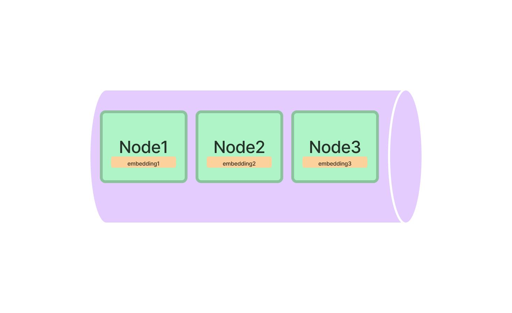

---

**`Source Node 2/2`**

**Document ID:** 2a114055-27b4-41ed-929a-caba37d5bbe0<br>**Similarity:** 0.7813584901476683<br>>**Text:** filename: ../../docs/guides/index_guide.md



How Each Index Works

This guide describes how each index works with diagrams. We also visually highlight our "Response Synthesis" modes.

Some terminology:
- **Node**: Corresponds to a chunk of text from a ...<br>

In [154]:
response.display()

In [156]:
response = index.query('Show me how list index works.', similarity_top_k=2)

INFO:root:> [query] Total LLM token usage: 584 tokens
INFO:root:> [query] Total embedding token usage: 7 tokens


**`Final Response:`** List index works by taking a list of items and creating an index of each item in the list. This index can then be used to quickly search for a specific item in the list. The index is typically organized in a hierarchical structure, with each item in the list having its own entry in the index. This allows for quick retrieval of the item when searching. For example, in the image provided (../../docs/_static/indices/list.png), the list is organized into nodes, with each node containing a name and a price. This allows for quick retrieval of the item when searching for a specific name or price.

---

**`Source Node 1/2`**

**Document ID:** 2a114055-27b4-41ed-929a-caba37d5bbe0<br>**Similarity:** 0.7828760953434136<br>**Text:** filename: ../../docs/guides/index_guide.md



How Each Index Works

This guide describes how each index works with diagrams. We also visually highlight our "Response Synthesis" modes.

Some terminology:
- **Node**: Corresponds to a chunk of text from a ...<br>

---

**`Source Node 2/2`**

**Document ID:** 6578a915-6dd0-4b0a-be65-1585ba8be132<br>**Similarity:** 0.7790688893753183<br>**Text:** filename: ../../docs/_static/indices/list.png

<s_menu><s_nm> Node2</s_nm><s_price> Node3</s_price></s_menu><s_total></s_total>...<br>**Image:**

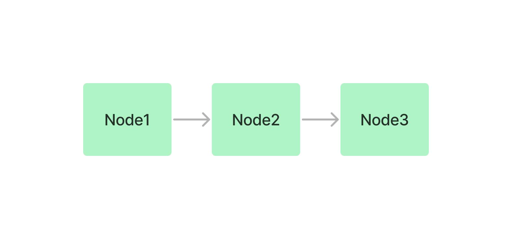

In [157]:
response.display()